# Monte Carlo simulation of X-ray imaging

The two main interaction processes between photon and matter is the photoelectric effect and Compton scattering. The photoelectric effect is a process where an electron with energy E is absorbed by an atom. The process where a photon interacts with an outer electron of an atom, leading to a change in the photons energy and direction is known as Compton scattering. When taking these two effects into account, we assume that there is a probability p of a photon being absorbed or scattered when moving a small distance x to $x+\Delta x$. (And a probability of 1-p of it moving through unhindered.)
If we assume that the intensity of a photon beam is equal to $I(x)$, the above assumption would mean that the expected intensity of the beam at $x + \Delta x$ is equal to 

$I(x+\Delta x) = I(x)(1-p) + 0*p \,\,\,\,(1)$.

The first part of this notebook will look at x-ray imaging in one direction. The space it moves through is discretized into N different sections, where each distance is given by $\Delta x$. In this project the assumption that $p = \mu \Delta x$ will be made, where $\mu$ is the so-called attenuation coefficient. The attenuation coefficient describes the extent at which the radiant flux of a beam reduces as it moves through a material.

Rearranging the terms in (1), plugging in the definition of the probability p, and considering infitesimal steps ($\Delta x \rightarrow 0$), we get the differential equation

$\frac{dI(x)}{dx} = -\mu I(x) \,\,\,\,(2)$.

This equation has the analytical solution 

$I(x) = I_0 e^{-\mu x} \,\,\,\, (3)$,

where $I_0$ is the initial intensity of the beam. This analytical solution will be used to measure how good the numerical approximation is.

For the later parts of the project, some data of attenuation coefficients will be used. These are structured in datafiles giving the attenuation coefficient of the different materials for different energies.

In [1]:
#%matplotlib notebook
# Importing necessary libraries
import numpy as np # Numpy for handling arrays
import matplotlib.pyplot as plt # Matplotlib to do the plotting
from mpl_toolkits.mplot3d import Axes3D # For 3D plots
from IPython.display import HTML, display # For tables
import tabulate # Tables
import simulation_functions as sf

# Fixing some parameters for all of the figures
plt.rcParams.update({'axes.grid': True, 'grid.linestyle' : "--", 'figure.figsize' : (9.5,6)})

In [2]:
%%html 
<style>
.output_wrapper button.btn.btn-default, .output_wrapper .ui-dialog-titlebar {
    display: none;
} </style>

Above block is just to remove the interactive buttons that comes with the notebook backend to get cleaner figures.

### Part 1

In this part a one-dimensional beam of photons will be sent through a material with dampening coefficient, $\mu$.
The result from the Monte-Carlo method and the analytical solution will be compared.
In the end the stability of the Monte-Carlo method will be looked into by comparing different number of photons and different steplengths $\Delta x$. This part is mainly to check that the numerical solver corresponds with the analytical solution.

In [3]:
# Defining some parameters for the first part
# Adding _1 to the parameters to keep them separated from the other parts
'''
- width: the width of the material (cm)
- n_steps: the number of steps
- x: the points along the x-axis
- n_photons: number of photons
- my: the attenuation coefficient of the material, cm^-1
'''

width_1 = 10
n_steps_1 = 100
x_1 = np.linspace(0, width_1, n_steps_1 + 1)
n_photons_1 = 10000
my1 = 0.1 * np.ones(n_steps_1)

In [4]:
# In both the numerical and the analytical solution, the intensity is scaled to 1

# Numerical simulation given the parameters above
I1 = sf.simulate_photons(n_photons_1, n_steps_1, width_1, my1) 

# Analytical solution given the parameters:
I_analytical = np.exp(-my1[0] * x_1) # For this part we assume attenuation coefficient to be constant

#### Figure 1: Comparison between Monte Carlo method and Analytical solution

In the figure below the accuracy of the numerical simulation is shown for different number of photons.

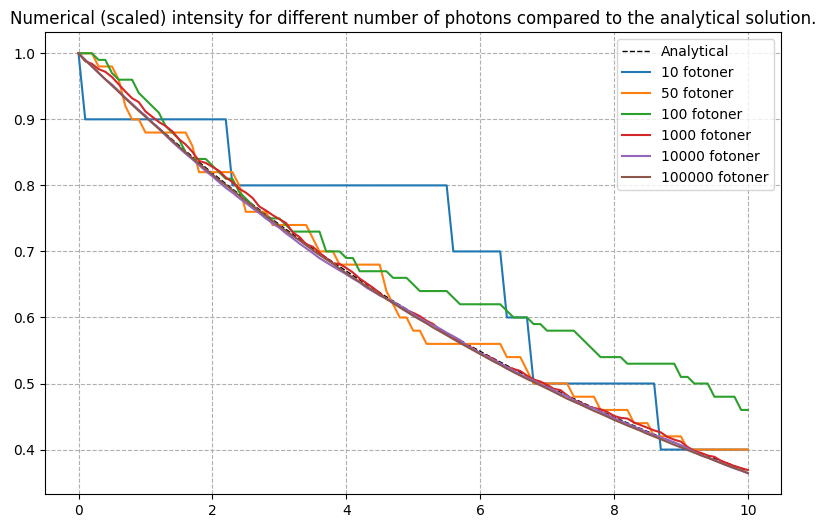

In [5]:
# Comparing the analytical solution with the numerical solution
fig1 = plt.figure()
plt.plot(x_1, I_analytical, label = 'Analytical', linestyle = '--', color = 'black', linewidth = 1)

number_of_photons = [10, 50, 100, 1000, 10000, 100000]

for i, n_photon in enumerate(number_of_photons):
    # Going through the different numbers of photons
    I_numerical = sf.simulate_photons(n_photon, n_steps_1, width_1, my1)
    plt.plot(x_1, I_numerical, label = f"{n_photon} fotoner")
plt.title("Numerical (scaled) intensity for different number of photons compared to the analytical solution.")
plt.legend()
plt.show()

From the plot above it is clear to see that as the number of photons in the photon beam increases, the Monte Carlo approximation approaches the analytical solution. 

Now, the numerical approximation and the analytical solution will be compared more accurately. To this end the function to simulate photons will be run a thousand times for each different number of photons. Afterwards, the mean distance and standard deviation from the analytical solution calculated.

In [6]:
tabell = []
for i, n_photon in enumerate(number_of_photons):
    distance = np.zeros(n_steps_1 + 1)
    for j in range(1000):
        I = sf.simulate_photons(n_photon, n_steps_1, width_1, my1)
        
        distance += abs(I_analytical - I) # Summing up the total distances of all the runs
    
    # Calculate averages and standard deviations
    mean_error = np.mean(distance/1000) 
    std_error = np.std(distance/1000)
    
    # Adding result to table for easier
    tabell.append([f"{n_photon}", round(mean_error, 4), round(std_error, 4)])
    
# Using library tabulate to get a good looking table
# Changing the html code to get a centered table
display(HTML('<table width="80%" style="margin: 0px auto;"><thead><tr><th style="text-align: center;">' 
      + tabulate.tabulate(tabell, headers=["Photons", "Mean error I/I0", "Standard deviation I/I0"], 
                               tablefmt="html")[52:-8] + "</table>"))

Photons,Mean error I/I0,Standard deviation I/I0
10,0.1119,0.0258
50,0.0495,0.0116
100,0.0343,0.0079
1000,0.0107,0.0025
10000,0.0037,0.0009
100000,0.0016,0.0005


From the table above, it is clear that as the number of photons increases, the error and standard deviation decreases. The difference from 10,000 to 100,000 is not that big, but the run time is much greater. This means that it might be more efficient to use 10,000 for later simulations.

#### Figure 2
The number of photons used in the simulation is not the only parameter that can effect the quality of the numerical approximation. The grid size, i.e. the number of steps used in the simulation is also important.

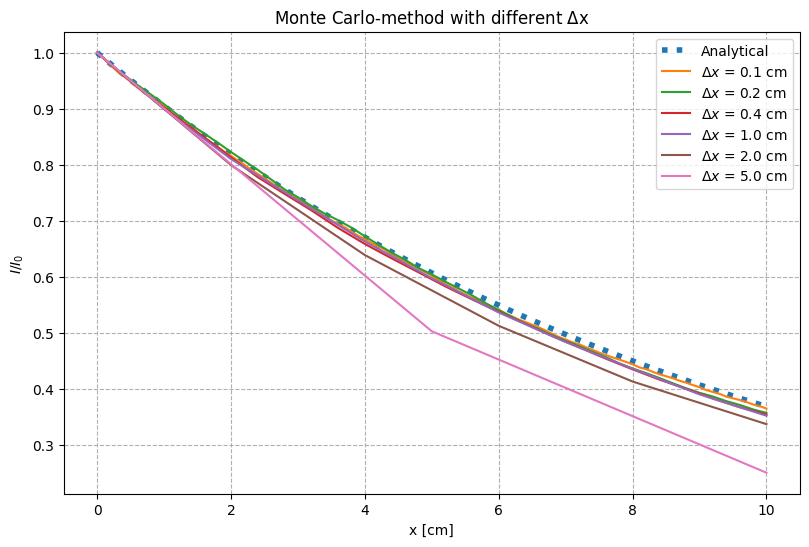

In [8]:
fig2 = plt.figure()
plt.plot(x_1, I_analytical, label = "Analytical", linestyle = 'dotted', linewidth = 4)
n_steps_1_2 = [100, 50, 25, 10, 5, 2] # Different number of steps to compare
dx1_2 = width_1 / np.array(n_steps_1_2)

# Simulate 100,000 photons through the material with the steplengths definied above
for i, n_step in enumerate(n_steps_1_2):
    x1_2 = np.linspace(0, width_1, n_step + 1) # Need new x-axis for each simulation
    my1_2 = 0.1 * np.ones(n_step) # Dimension of my changes with number of steps
    I = sf.simulate_photons(n_photons_1, n_step, width_1, my1_2) # Do the simulation
    
    plt.plot(x1_2, I, label = f"$\Delta x$ = {dx1_2[i]} cm")

plt.title("Monte Carlo-method with different $\Delta$x"); plt.xlabel("x [cm]"); plt.ylabel("$I/I_0$"); plt.legend()
plt.show()

From the plot above it is apparent that a large number of steps (a small steplength) is needed to capture the curvature of the analytical solution. 

### Part 2

In this part two different photon beams will be simulated. One will go through only tissue, and the other will first go through tissue, then through bone and in the end through tissue again. Their contrast will be compared at different energy levels. The attenuation of bone and tissue at different energies is given in the data folder.
The data file for bone was collected from 
https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html,

and the data file for (soft) tissue was collected from
https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/tissue.html.

The first column contains the energy, and the second one the mass-attenuation coefficient. To get back the attentuation coefficient 
$\mu $, these values will have to be devided by the density, $\rho$. I will use $\rho_{tissue} = 1.02 g/cm^3$ and $\rho_{bone} = 1.92 g/cm^3$.

This part of the project is supposed to simulate x-rays, where some of the rays will move through some soft tissue and some bone, and others will move through only tissue. After the simulation is finished, the difference in concentration will be compared to see if any contrast may be visible.

Since the energy of x-rays used in medicine lies between 10keV and 100keV, the simulations in this part will consider energies in this range.

In [9]:
# Constants for part 2
tissue_dens = 1.02 #g/cm^3
bone_dens = 1.92 #g/cm^3
n_steps_2 = 1000
width_2 = 3 #cm
n_photons_2 = 100000

# reading in the datafiles for attenuation coefficients
energy_tissue, my_tissue = np.loadtxt("data/tissue.txt", delimiter=',', unpack=True)
energy_bone, my_bone = np.loadtxt("data/bone.txt", delimiter=',', unpack=True)

# Multiplying with density to get correct attenuation coefficient
my_tissue *= tissue_dens
my_bone *= bone_dens

#### Figure 3: Attenuation coefficients as function of energy

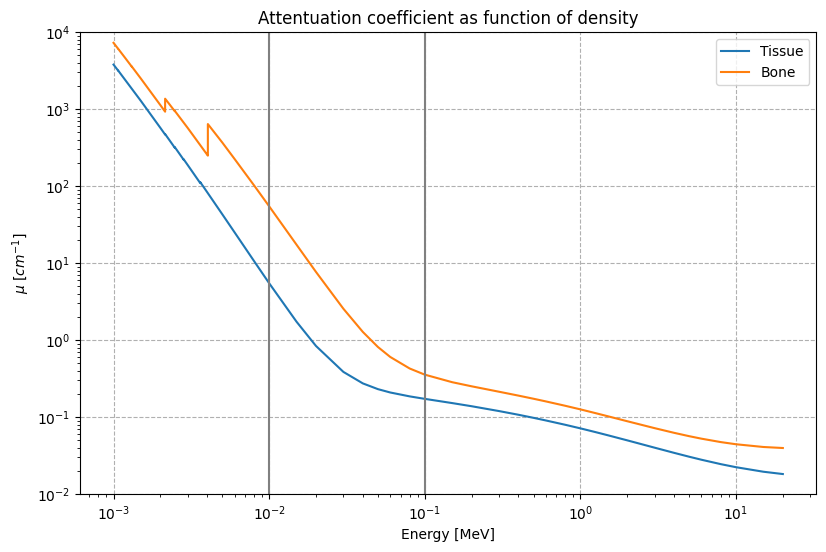

In [10]:
fig5 = plt.figure()
energy_lower, energy_higher = 1e-2, 1e-1
plt.loglog(energy_tissue, my_tissue, label = "Tissue")
plt.loglog(energy_bone, my_bone, label = "Bone")
plt.title("Attentuation coefficient as function of density")
plt.xlabel("Energy [MeV]"); plt.ylabel("$\mu$ $[cm^{-1}]$"); plt.legend(); plt.ylim(1e-2, 1e4)
plt.vlines(energy_lower, 0, 1e4, color = "grey"); plt.vlines(energy_higher, 0, 1e4, color = "grey")
plt.show()

### Part 3
In this part photon beams will be sent through different 3d objects at different energies. 2d images will be created by sending the photon beams through the three different axise.